Skill Gaps Identified:
   Intern_ID Gap_Level         Suggested_Training
0          1      High  Data Science Fundamentals
1          2      High        General Programming
2          3      High  Data Science Fundamentals


/tmp/ipython-input-1339540662.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intern_df['Intern_ID'], y=similarities_list, palette=colors)
/tmp/ipython-input-1339540662.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_features, palette='coolwarm')


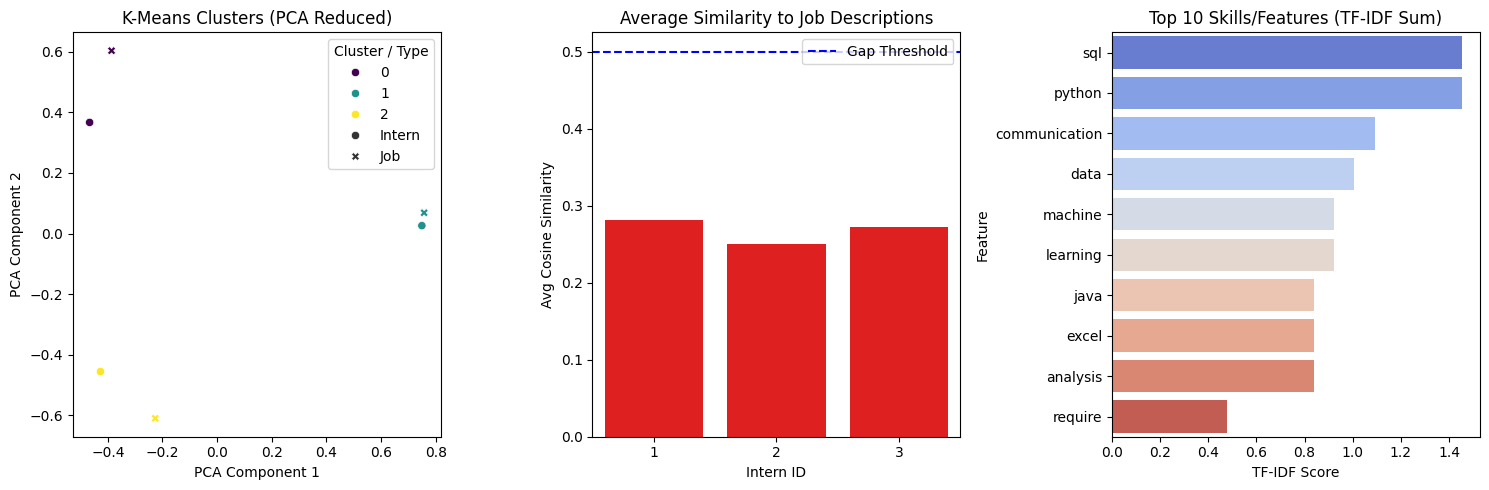

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with real data as needed)
intern_data = {
    'Intern_ID': [1, 2, 3],
    'Skills': [
        'Python, Machine Learning, SQL',
        'Java, Data Analysis, Excel',
        'Python, SQL, Communication'
    ]
}
job_data = {
    'Job_ID': [1, 2, 3],
    'Description': [
        'Looking for Python, Machine Learning, SQL expertise for data roles.',
        'Need Java, Data Analysis, Excel skills for analytics positions.',
        'Require Python, SQL, Communication for software development.'
    ]
}

intern_df = pd.DataFrame(intern_data)
job_df = pd.DataFrame(job_data)

# Preprocess text
stop_words = set(stopwords.words('english'))
def preprocess(text):
    return ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])

intern_df['Processed_Skills'] = intern_df['Skills'].apply(preprocess)
job_df['Processed_Description'] = job_df['Description'].apply(preprocess)

# Combine all text for TF-IDF
all_texts = list(intern_df['Processed_Skills']) + list(job_df['Processed_Description'])

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Split matrices
intern_vectors = tfidf_matrix[:len(intern_df)]
job_vectors = tfidf_matrix[len(intern_df):]

# K-Means Clustering (e.g., 3 clusters for small data)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(tfidf_matrix)
intern_clusters = kmeans.predict(intern_vectors)
job_clusters = kmeans.predict(job_vectors)

# Gap Analysis
gaps = []
similarities_list = []
for i, intern in intern_df.iterrows():
    intern_vec_dense = intern_vectors[i].toarray().reshape(1, -1)
    job_vecs_dense = job_vectors.toarray()
    similarities = cosine_similarity(intern_vec_dense, job_vecs_dense)[0]
    avg_similarity = similarities.mean()
    similarities_list.append(avg_similarity)
    if avg_similarity < 0.5:
        gaps.append({
            'Intern_ID': intern['Intern_ID'],
            'Gap_Level': 'High' if avg_similarity < 0.3 else 'Medium',
            'Suggested_Training': 'Data Science Fundamentals' if 'python' in intern['Processed_Skills'] else 'General Programming'
        })

# Output results
gap_df = pd.DataFrame(gaps)
print("Skill Gaps Identified:")
print(gap_df)

# Visualizations
plt.figure(figsize=(15, 5))

# 1. Cluster Scatter Plot
pca = PCA(n_components=2, random_state=42)
tfidf_2d = pca.fit_transform(tfidf_matrix.toarray())
labels = ['Intern'] * len(intern_df) + ['Job'] * len(job_df)
clusters = list(intern_clusters) + list(job_clusters)

plt.subplot(1, 3, 1)
sns.scatterplot(x=tfidf_2d[:, 0], y=tfidf_2d[:, 1], hue=clusters, style=labels, palette='viridis')
plt.title('K-Means Clusters (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster / Type')

# 2. Gap Bar Chart
plt.subplot(1, 3, 2)
colors = ['red' if sim < 0.5 else 'green' for sim in similarities_list]
sns.barplot(x=intern_df['Intern_ID'], y=similarities_list, palette=colors)
plt.axhline(y=0.5, color='blue', linestyle='--', label='Gap Threshold')
plt.title('Average Similarity to Job Descriptions')
plt.xlabel('Intern ID')
plt.ylabel('Avg Cosine Similarity')
plt.legend()

# 3. Top Skills Bar Chart
feature_names = vectorizer.get_feature_names_out()
tfidf_sums = tfidf_matrix.sum(axis=0).A1
top_indices = tfidf_sums.argsort()[-10:][::-1]  # Top 10
top_features = [feature_names[i] for i in top_indices]
top_scores = [tfidf_sums[i] for i in top_indices]

plt.subplot(1, 3, 3)
sns.barplot(x=top_scores, y=top_features, palette='coolwarm')
plt.title('Top 10 Skills/Features (TF-IDF Sum)')
plt.xlabel('TF-IDF Score')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()
